In [1]:
import os
import importlib
from timeit import timeit
import logging
import sys
import importlib
import time
import multiprocessing as mp
import multiprocessing.pool

import numpy as np
import pandas as pd
import scipy
import h5py
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numba
import sklearn.linear_model

import ms_utils
import browser
import interface
import ms_database
import ms_run_files

import sandbox

import line_profiler
profile = line_profiler.LineProfiler()
# heat.evolve = profile(heat.evolve)
# profile.print_stats()

def reload():
    importlib.reload(ms_run_files)
    importlib.reload(ms_utils)
    importlib.reload(browser)
    importlib.reload(interface)
    importlib.reload(sandbox)
    importlib.reload(ms_database)
   

In [2]:
in_folder = "/home/sander/projects/tenzer"
evis = {}
inets = {}
for file_name in sorted(os.listdir(in_folder)):
    if file_name.endswith(".evidence.hdf"):
        in_file_name = os.path.join(in_folder, file_name)
        evi = ms_run_files.Evidence(in_file_name)
        run_name = evi.run_name
        evis[run_name] = evi
        inet = evi.ion_network
        inets[run_name] = inet

self_run = sorted(inets)[0]
self_inet = inets[self_run]
self_evi = evis[self_run]

In [3]:
# reproducibility_counts = self_evi.get_nodes()
# alignment_indices = [
#      np.flatnonzero(reproducibility_counts == i) for i in range(1 + self_evi.run_count)
# ]
# alignments = [
#     np.empty(
#         (alignment_indices[i].shape[0], i), np.int64
#     ) for i in range(1 + self_evi.run_count)
# ]
# alignment_masks = [
#     np.empty(
#         (alignment_indices[i].shape[0], i), np.bool_
#     ) for i in range(1 + self_evi.run_count)
# ]

alignment_matrix = np.empty(
    (self_inet.node_count, self_evi.run_count), np.int64
)
alignment_matrix_mask = np.zeros(
    (self_inet.node_count, self_evi.run_count), np.bool_
)
alignment_matrix_intensities = np.zeros(
    (self_inet.node_count, self_evi.run_count), np.float64
)

for index, (other_run, other_evi) in enumerate(sorted(evis.items())[1:]):
    self_ali = self_evi.get_nodes(other_evi)
    other_ali = other_evi.get_nodes(self_evi)
    alignment_matrix[self_ali, index] = other_ali
    alignment_matrix_mask[self_ali, index] = True
    alignment_matrix_intensities[self_ali, index] = 2**other_evi.ion_network.get_ion_coordinates(
        "FRAGMENT_LOGINT",
        other_ali
    )

In [4]:
a_reproducibility = 1 + np.sum(alignment_matrix_mask[:, 1::2], axis=1)
b_reproducibility = np.sum(alignment_matrix_mask[:, ::2], axis=1)
total_reproducibility = a_reproducibility + b_reproducibility

b_intensities = np.sum(alignment_matrix_intensities[:, ::2], axis=1) / b_reproducibility
a_intensities = (
    2**self_inet.get_ion_coordinates(
        "FRAGMENT_LOGINT"
    ) + np.sum(alignment_matrix_intensities[:, 1::2], axis=1)
) /  a_reproducibility

logfcs = np.log2(a_intensities) - np.log2(b_intensities)
valid_logfcs = (a_reproducibility > 0) & (b_reproducibility > 0)

<ipython-input-4-fc881e871bbf>:5: RuntimeWarning: invalid value encountered in true_divide
  b_intensities = np.sum(alignment_matrix_intensities[:, ::2], axis=1) / b_reproducibility
<ipython-input-4-fc881e871bbf>:12: RuntimeWarning: divide by zero encountered in log2
  logfcs = np.log2(a_intensities) - np.log2(b_intensities)


<IPython.core.display.Javascript object>


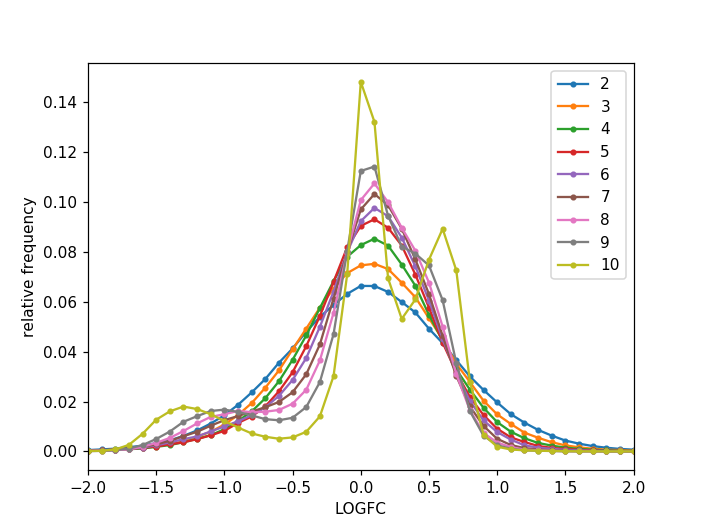

In [5]:
%matplotlib notebook

for i in range(2, 1 + 10):
    reps = logfcs[valid_logfcs & (total_reproducibility == i)]
    a, b = np.unique(np.round(reps, 1), return_counts=True)
    plt.plot(a, b / np.sum(b), marker=".")

plt.xlim((-2, 2))
plt.xlabel("LOGFC")
plt.ylabel("relative frequency")
plt.legend(range(2, 1 + 10))

In [51]:
ecoli = logfcs < -0.5
yeast = logfcs > 0.2

<ipython-input-51-08c2d132f124>:1: RuntimeWarning: invalid value encountered in less
  ecoli = logfcs < -0.5
<ipython-input-51-08c2d132f124>:2: RuntimeWarning: invalid value encountered in greater
  yeast = logfcs > 0.2


In [7]:
left_indices, right_indices = self_inet.get_edges(
    return_as_pairs=True,
)
positive_counts = self_evi.get_edges()
negative_counts = self_evi.get_edges(positive=False)
left_overlaps = alignment_matrix_mask[left_indices]
right_overlaps = alignment_matrix_mask[right_indices]
overlaps = np.sum(left_overlaps&right_overlaps, axis=1)
logfc_deviations = np.abs(
    logfcs[left_indices] - logfcs[right_indices]
)

In [8]:
# evidence = (
#     positive_counts - negative_counts
# ) / (
#     positive_counts + negative_counts
# ) * positive_counts

evidence = positive_counts - negative_counts

In [35]:
overlap = 4
# int_filter = 1000
# logints = self_inet.get_ion_coordinates("FRAGMENT_LOGINT")
selected_edges = overlaps == overlap
# selected_edges &= (logints[left_indices] < int_filter)  & (logints[right_indices] < int_filter) 

selected_left_indices = left_indices[selected_edges]
selected_right_indices = right_indices[selected_edges]
selected_evidence = evidence[selected_edges]
selected_nan_values = np.isnan(selected_evidence)
selected_nan_values |= np.isinf(selected_evidence)
selected_evidence_values = np.unique(selected_evidence[~selected_nan_values])

selected_logfc_deviations = logfc_deviations[selected_edges]

<IPython.core.display.Javascript object>


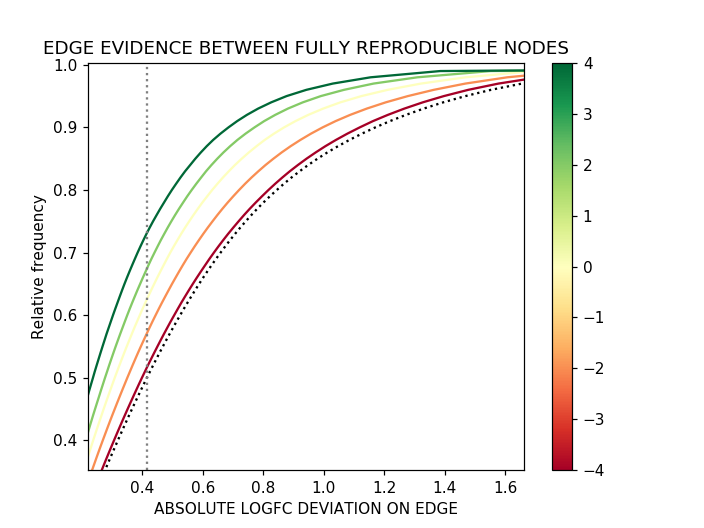

Text(0.5, 1.0, 'EDGE EVIDENCE BETWEEN FULLY REPRODUCIBLE NODES')

In [36]:
%matplotlib notebook

color_mapper = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=np.min(selected_evidence_values),
        vmax=np.max(selected_evidence_values),
    ),
    cmap="RdYlGn"
)

random_right_indices = selected_right_indices.copy()
np.random.seed(100)
np.random.shuffle(random_right_indices)
random_logfc_deviation = np.abs(logfcs[selected_left_indices] - logfcs[random_right_indices])
nan_values = np.isnan(random_logfc_deviation)
nan_values |= np.isinf(random_logfc_deviation)
random_logfc_deviation = random_logfc_deviation[~nan_values]
plt.plot(
    np.percentile(random_logfc_deviation, range(101)),
    np.arange(101)/100,
    linestyle="dotted",
    c="black"
)

for evidence_value in selected_evidence_values:
    current = selected_evidence == evidence_value
    logfc_deviation = selected_logfc_deviations[current]
    nan_values = np.isnan(logfc_deviation)
    nan_values |= np.isinf(logfc_deviation)
    logfc_deviation = logfc_deviation[~nan_values]
    plt.plot(
        np.percentile(logfc_deviation, range(101)),# - np.percentile(random_logfc_deviation, range(101)),
        np.arange(101)/100,
        c=color_mapper.to_rgba(evidence_value)
    )
    
plt.axvline(
    np.median(random_logfc_deviation),
    linestyle="dotted",
    c="grey"
)
# plt.legend(list(np.round(evidence_values, 1)) + ["RANDOM"])
plt.colorbar(color_mapper)
plt.xlabel("ABSOLUTE LOGFC DEVIATION ON EDGE")
plt.ylabel("Relative frequency")
plt.title("EDGE EVIDENCE BETWEEN FULLY REPRODUCIBLE NODES")

<IPython.core.display.Javascript object>


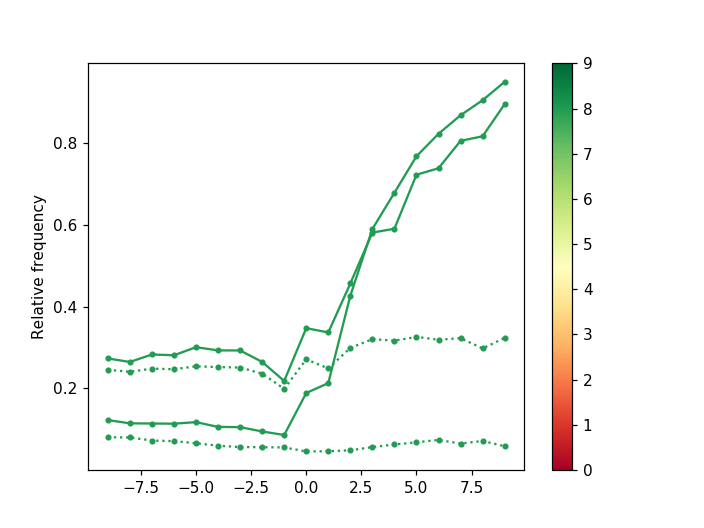

Text(0, 0.5, 'Relative frequency')

In [54]:
%matplotlib notebook

color_mapper = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=np.min(0),
        vmax=np.max(self_evi.run_count),
    ),
    cmap="RdYlGn"
)

# for overlap in range(1, self_evi.run_count):
#     selected_edges = overlaps == overlap
if True:
    selected_edges = overlaps >= 1
    # selected_edges &= ecoli[left_indices] | ecoli[right_indices]

    selected_left_indices = left_indices[selected_edges]
    selected_right_indices = right_indices[selected_edges]
    selected_evidence = evidence[selected_edges]
    selected_nan_values = np.isnan(selected_evidence)
    selected_nan_values |= np.isinf(selected_evidence)
    selected_evidence_values = np.unique(selected_evidence[~selected_nan_values])


    ecoli_hit_rates = np.empty(selected_evidence_values.shape[0], np.float64)
    yeast_hit_rates = np.empty(selected_evidence_values.shape[0], np.float64)
    ecoli_random_rates = np.empty(selected_evidence_values.shape[0], np.float64)
    yeast_random_rates = np.empty(selected_evidence_values.shape[0], np.float64)
#     total_count = np.sum(selected_edges)
    for i, evidence_value in enumerate(selected_evidence_values):
        current = selected_evidence == evidence_value
        total_count = np.sum(current)
        
        left_ecoli = ecoli[selected_left_indices[current]]
        right_ecoli = ecoli[selected_right_indices[current]]
        ecoli_hit_rate = np.sum(left_ecoli & right_ecoli) / np.sum(left_ecoli | right_ecoli)
        ecoli_hit_rates[i] = ecoli_hit_rate
        random_right_ecoli = right_ecoli.copy()
        np.random.shuffle(random_right_ecoli)
        ecoli_random_rate = np.sum(left_ecoli & random_right_ecoli) / np.sum(left_ecoli | random_right_ecoli)
        ecoli_random_rates[i] = ecoli_random_rate
        
        left_yeast = yeast[selected_left_indices[current]]
        right_yeast = yeast[selected_right_indices[current]]
        yeast_hit_rate = np.sum(left_yeast & right_yeast) / np.sum(left_yeast | right_yeast)
        yeast_hit_rates[i] = yeast_hit_rate
        random_right_yeast = right_yeast.copy()
        np.random.shuffle(random_right_yeast)
        yeast_random_rate = np.sum(left_yeast & random_right_yeast) / np.sum(left_yeast | random_right_yeast)
        yeast_random_rates[i] = yeast_random_rate

    plt.plot(
        selected_evidence_values,
        ecoli_hit_rates,
        marker=".",
        c=color_mapper.to_rgba(overlap)
    )
    plt.plot(
        selected_evidence_values,
        ecoli_random_rates,
        marker=".",
        c=color_mapper.to_rgba(overlap),
        linestyle="dotted",
    )
    plt.plot(
        selected_evidence_values,
        yeast_hit_rates,
        marker=".",
        c=color_mapper.to_rgba(overlap)
    )
    plt.plot(
        selected_evidence_values,
        yeast_random_rates,
        marker=".",
        c=color_mapper.to_rgba(overlap),
        linestyle="dotted",
    )

# plt.axvline(
#     np.median(random_logfc_deviation),
#     linestyle="dotted",
#     c="grey"
# )
# # plt.legend(list(np.round(evidence_values, 1)) + ["RANDOM"])
plt.colorbar(color_mapper)
# plt.xlabel("ABSOLUTE LOGFC DEVIATION ON EDGE")
plt.ylabel("Relative frequency")
# plt.title("EDGE EVIDENCE BETWEEN FULLY REPRODUCIBLE NODES")